## Google Colab Setup

### Setting up Google Colab with GPU support is a straightforward process. Here are the steps along with links to the official documentation:

1. Open Google Colab:
   Open your browser and go to Google Colab.

2. Sign in with Google Account:
   If you're not already signed in, sign in with your Google account.

3. Create a New Notebook:
   Click on "File" in the top left corner, then select "New Notebook" to create a new Colab notebook.

4. Change Runtime Type:
   Click on "Runtime" in the top menu, then select "Change runtime type." Choose "GPU" from the Hardware accelerator dropdown menu.

[Change runtime type documentation](https://colab.research.google.com/notebooks/basic_features_overview.ipynb#scrollTo=-_z3tY2D-RRs)

5. Verify GPU Availability:
   To verify that the GPU is successfully connected, you can run the following code snippet in a code cell:
   ```python
   import tensorflow as tf
   tf.test.gpu_device_name()
   ```
   It should output the name of your GPU if the GPU is connected.


6. Load Data and Start Coding:
   Now you can start coding in your notebook. Upload your datasets, write your code, and execute the cells.

   Remember that the GPU access provided by Colab is not unlimited. It has time restrictions, and if you exceed the allocated time, you might need to reconnect to a new GPU.

   By following these steps and referring to the provided documentation links, you should be able to set up and use Google Colab with GPU support for your machine learning or deep learning projects.





## Coding Exercise

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

2025-01-18 19:20:51.554874: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-18 19:20:51.705574: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-18 19:20:51.705604: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 19:20:51.705608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 19:20:51.774404: I tensorflow/core/platform/cpu_feature_g

'/device:GPU:0'

### Simple Neural Network Implementation

Objective: Complete a simple neural network.
This task will help you understand the fundamental mechanisms of neural networks, including the forward pass, backward pass (backpropagation), and basic optimization.

Problem Statement:
You are given a neural network that is performing really bad.
You are required to complete and improve it to perform  classification on a Fashion MNIST Dataset

Import all necessary libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler

### Dataset:

The dataset used is the Fashion-MNIST dataset, a dataset of Zalando's article images. It is intended as a drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It consists of 60,000 training images and 10,000 testing images. Each image is a 28x28 grayscale image, associated with a label from 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot.

### Train, Validation & Test split

- **Splitting the Dataset:** The dataset is split into training and testing sets. The `train=True` argument is used to load the training set, and `train=False` is used to load the testing set.

- **Creating a Validation Set:** A validation set is created from the training set. The indices of the training set are shuffled, and the first 20% of these indices are used for the validation set. The `SubsetRandomSampler` function is used to create samplers for the training and validation sets, which can be used to load batches of data.

In [3]:
## Fashion MNIST data loading
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples),
                                                                      # therefore we should add a comma after the values

#Load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

#Preparing for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


#### Sequential Model

The neural network model is defined as a `Sequential` model. The `Sequential` model is a linear stack of layers. It can be created by passing a list of layer instances to the constructor.


In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120,10)
        #defining the 20% dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc1(x)))
        #not using dropout on output layer
        x = F.tanh(self.fc2(x))

        return x

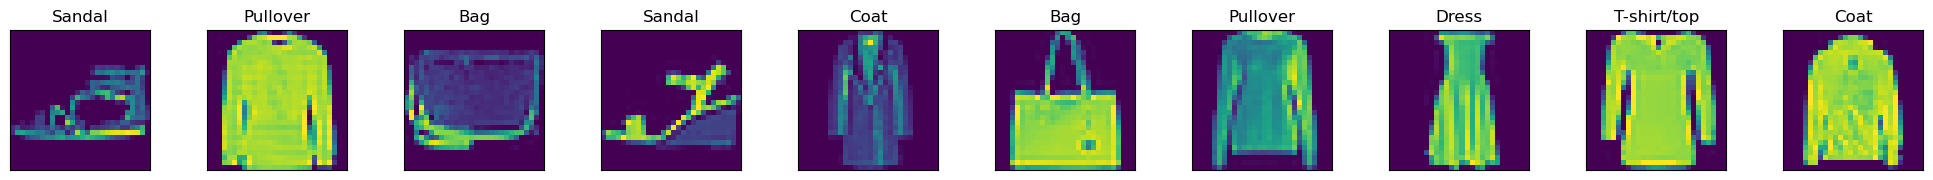

In [5]:
# visualizing images in gird
def imshow(img):
    img = img/2 + 0.5 #unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) #convert from tensor image

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy() #converting images to numpy for display

fig = plt.figure(figsize=(25,4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(trainset.classes[labels[idx]])


### Training Function:
This function trains the neural network model with stochastic gradient descent (SGD) as the optimizer and cross-entropy as the loss objective function.
The training process includes both forward and backward passes. The model's parameters are updated in each epoch.

### Testing Function:
After training the model, we'll evaluate the model's performance on testing dataset. The evaluation will be done based on the accuracy of the model, which is the proportion of correctly predicted samples.

In [6]:
class ModelTrainer:
    def __init__(self, model, learning_rate=1, num_epochs=100):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.train_loss = []
        self.test_loss = []

    def train_model(self, loader, epoch):
        self.model.train()
        loss_list = []
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_func(output, target)
            loss.backward()
            self.optimizer.step()
            loss_list.append(loss.item())
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx*len(data), len(loader.dataset),
                        100. * batch_idx / len(loader), loss.item()))
        avg_loss = sum(loss_list)/len(loss_list)
        self.train_loss.append(avg_loss)


    def test_model(self, loader):
        self.model.eval()
        test_loss = 0
        correct = 0
        loss_list = []
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                batch_loss = self.loss_func(output, target).item()  # Calculate the loss for this batch
                test_loss += batch_loss  # Add the batch loss to the total test loss
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                loss_list.append(batch_loss)  # Append the batch loss to the list

        avg_loss = sum(loss_list) / len(loss_list)
        self.test_loss.append(avg_loss)
        test_loss /= len(loader.dataset)
        accuracy = 100. * correct / len(loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(loader.dataset), accuracy))

    def run(self, trainloader, validloader):
        for epoch in range(self.num_epochs):
            self.train_model(trainloader, epoch)
            self.test_model(validloader)
        self.plot_loss()

    # TODO: Generate a plot of the training/testing loss vs. the number of epochs. (10pts)
    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        
        epochs = range(1, len(self.train_loss) + 1)
        plt.plot(epochs, self.train_loss, 'b-', label='Training Loss')
        plt.plot(epochs, self.test_loss, 'r-', label='Validation Loss')
        
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Time')
        plt.legend()
        plt.grid(True)
        
        plt.show()


Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.278148

Test set: Average loss: 0.0159, Accuracy: 28127/60000 (47%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.191446

Test set: Average loss: 0.0144, Accuracy: 34080/60000 (57%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 1.081323

Test set: Average loss: 0.0139, Accuracy: 37527/60000 (63%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 1.021316

Test set: Average loss: 0.0136, Accuracy: 38658/60000 (64%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 0.952188

Test set: Average loss: 0.0136, Accuracy: 38773/60000 (65%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 1.013924

Test set: Average loss: 0.0133, Accuracy: 39185/60000 (65%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 1.059789

Test set: Average loss: 0.0132, Accuracy: 39167/60000 (65%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 0.924911

Test set: Average loss: 0.0130, Accuracy: 39761/60000 (66%)

Train Epoch: 8 [5984/60000 (99%)]	Loss: 1.108227

Test set: Average loss: 0.0132, Accuracy: 39689/60000 (66%)

T

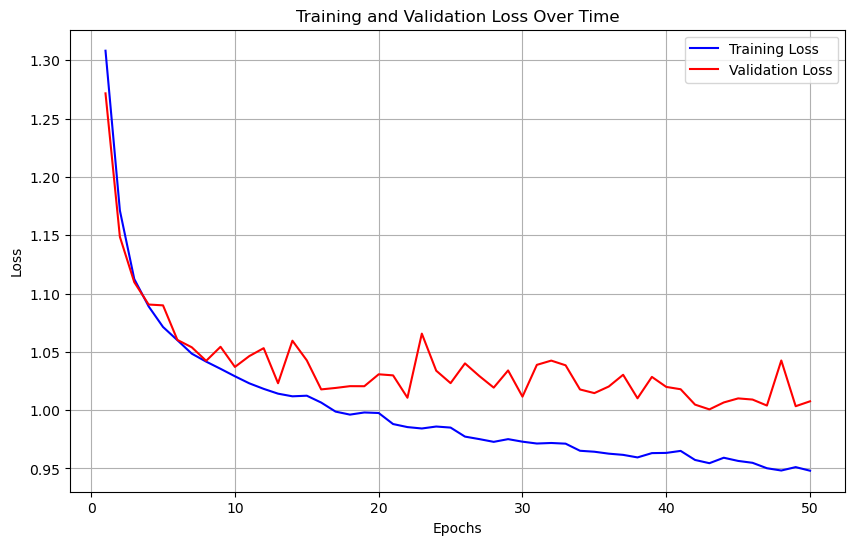


Test set: Average loss: 0.0162, Accuracy: 8467/10000 (85%)



In [7]:
model = Classifier()
trainer = ModelTrainer(model=model, learning_rate=0.5, num_epochs=50)
trainer.run(trainloader, validloader)
trainer.test_model(testloader)

DataLoader Performance Experiment



Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.257514

Test set: Average loss: 0.0158, Accuracy: 31028/60000 (52%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.191111

Test set: Average loss: 0.0150, Accuracy: 32288/60000 (54%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 1.175488

Test set: Average loss: 0.0140, Accuracy: 38447/60000 (64%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 1.030175

Test set: Average loss: 0.0140, Accuracy: 36528/60000 (61%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 1.068697

Test set: Average loss: 0.0133, Accuracy: 39223/60000 (65%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 1.220755

Test set: Average loss: 0.0134, Accuracy: 38737/60000 (65%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 1.020419

Test set: Average loss: 0.0136, Accuracy: 37746/60000 (63%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 0.909098

Test set: Average loss: 0.0132, Accuracy: 39460/60000 (66%)

Train Epoch: 8 [5984/60000 (99%)]	Loss: 1.020358

Test set: Average loss: 0.0131, Accuracy: 39630/60000 (66%)

T

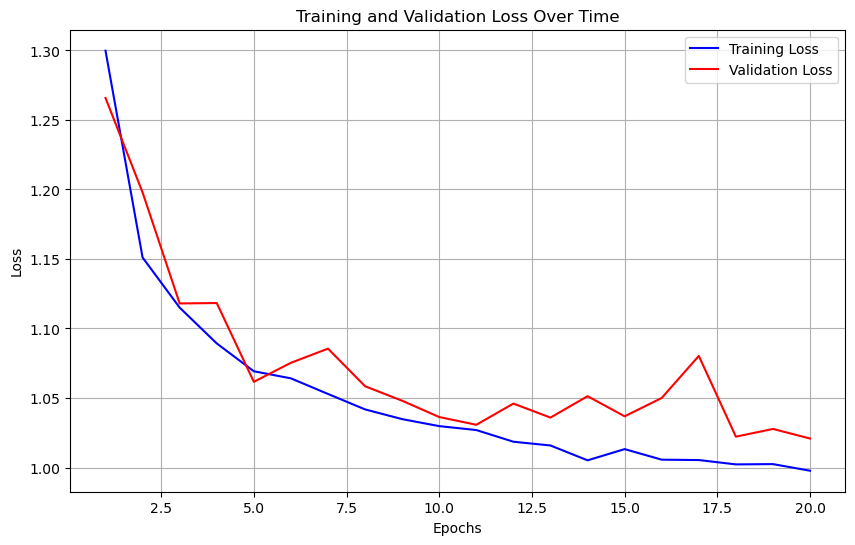


Test set: Average loss: 0.0162, Accuracy: 8298/10000 (83%)

Time taken: 76.68 seconds with default DataLoader num_workers=0 and pin_memory=False
Number of cores: 16
Number of workers: 16
Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.100466

Test set: Average loss: 0.0145, Accuracy: 33321/60000 (56%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.137480

Test set: Average loss: 0.0144, Accuracy: 37134/60000 (62%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 1.193655

Test set: Average loss: 0.0142, Accuracy: 36653/60000 (61%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 1.184026

Test set: Average loss: 0.0132, Accuracy: 39488/60000 (66%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 1.134857

Test set: Average loss: 0.0135, Accuracy: 38557/60000 (64%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 1.149212

Test set: Average loss: 0.0144, Accuracy: 36592/60000 (61%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 1.093036

Test set: Average loss: 0.0134, Accuracy: 38648/60000 (64%)

Train Epoch: 7 [5984/60000 (99%)]	L

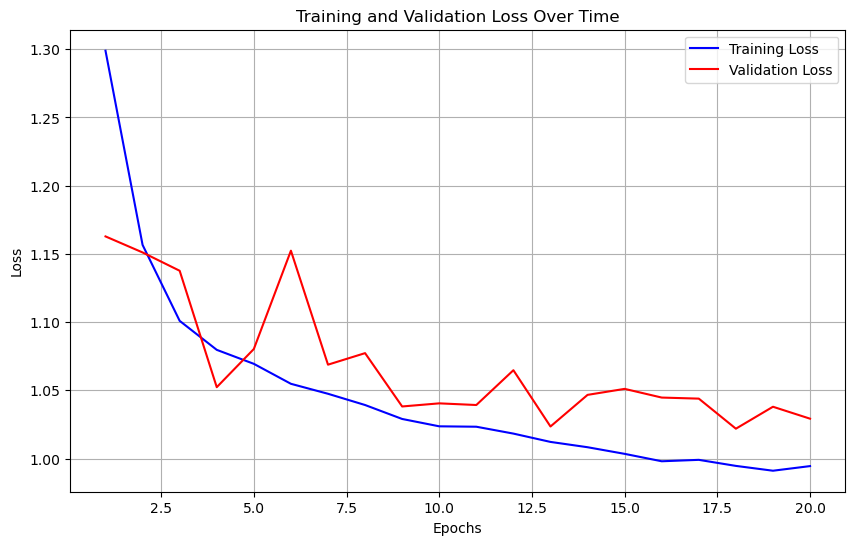


Test set: Average loss: 0.0165, Accuracy: 8343/10000 (83%)

Time taken: 38.32 seconds with DataLoader num_workers=16 and pin_memory=True


In [8]:
import time
# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

start_time = time.time()
model = Classifier()
trainer = ModelTrainer(model=model, learning_rate=0.5, num_epochs=20)
trainer.run(trainloader, validloader)
trainer.test_model(testloader)
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds with default DataLoader num_workers=0 and pin_memory=False")

# Data Loader
import multiprocessing
num_cores = multiprocessing.cpu_count()
num_workers = num_cores * 2
num_workers = 16 if num_workers > 16 else num_workers
print(f"Number of cores: {num_cores}")
print(f"Number of workers: {num_workers}")

trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64, num_workers=num_workers, pin_memory=True)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64, num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=num_workers, pin_memory=True)

start_time = time.time()
model = Classifier()
trainer = ModelTrainer(model=model, learning_rate=0.5, num_epochs=20)
trainer.run(trainloader, validloader)
trainer.test_model(testloader)
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds with DataLoader num_workers={num_workers} and pin_memory=True")

#### Task 1: Visualize the model's correct and incorrect predictions on the testing dataset using a confusion Matrix.(10 pts)

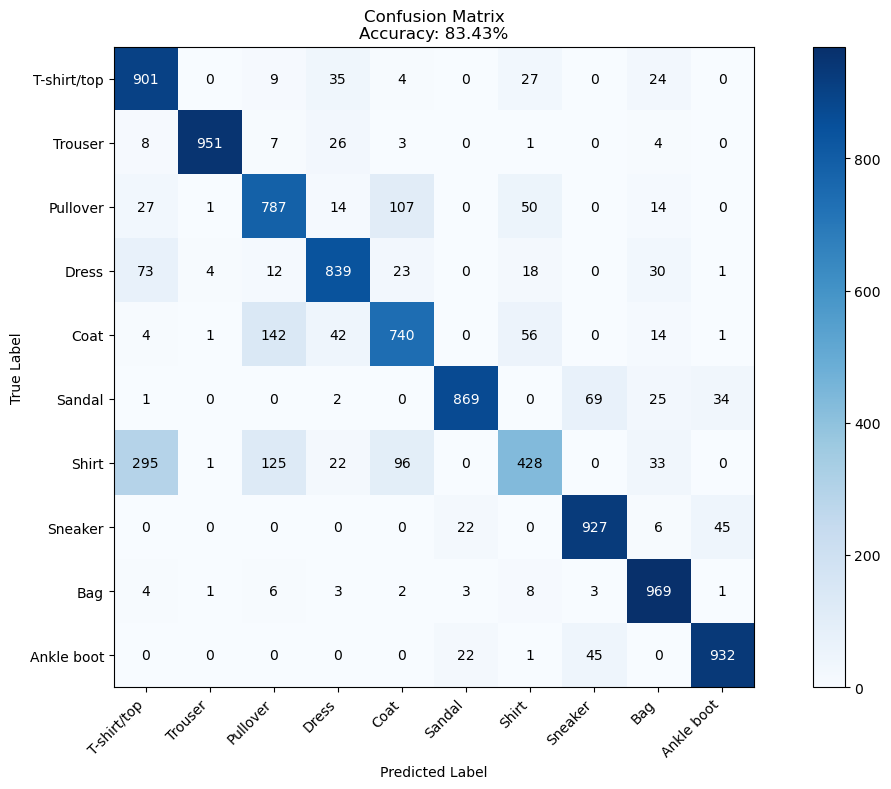

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, testloader, class_names):
    model.eval()
    n_classes = len(class_names)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    with torch.no_grad():
        for data, target in testloader:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            data, target = data.to(device), target.to(device)
            
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            
            for t, p in zip(target.cpu().numpy(), predicted.cpu().numpy()):
                cm[t, p] += 1
    
    accuracy = np.trace(cm) / np.sum(cm) * 100
    
    plt.figure(figsize=(12, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}%')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

class_names = trainset.classes
plot_confusion_matrix(model, testloader, class_names)

- Analysis: Looking at the numbers, our model does a pretty good job overall with 83% accuracy. It's really good at spotting bags, boots, and sneakers - barely makes any mistakes there.
Basic stuff like trousers and t-shirts? Also pretty solid. But it gets kind of confused with shirts - often thinks they're t-shirts, which makes sense since they look really similar. Same thing happens between pullovers and coats sometimes.
Basically, when it messes up, it's usually between things that look alike - which is exactly what you'd expect from a computer looking at black and white pictures!

### Machine learning involves a lot of experimentation. You might not always see large improvements, but every observation helps you understand how different parameters and design choices affect the model's performance. Focus on interpreting the results, not just achieving the best accuracy.

#### Task 2: Experiment with different learning rates and report your observations. Explain why the model performs better with some learning rates and worse with others. (10 pts)

For example, Keeping the other parameters the same, pick a high learning rate and observe the lose curve, accuracy. Then pick a low learning rate and observe the lose curve, accuracy. Find an optimal learning rate for your model and explain How learning rate affects the accuracy and lose change? What is the reason for this change?

Starting learning rate experiments...

Training with learning rate = 0.01
Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.466877

Test set: Average loss: 0.0182, Accuracy: 33615/60000 (56%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.243661

Test set: Average loss: 0.0165, Accuracy: 34860/60000 (58%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 1.222334

Test set: Average loss: 0.0157, Accuracy: 35347/60000 (59%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 1.157910

Test set: Average loss: 0.0153, Accuracy: 35572/60000 (59%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 1.281956

Test set: Average loss: 0.0150, Accuracy: 35685/60000 (59%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 1.121388

Test set: Average loss: 0.0148, Accuracy: 35855/60000 (60%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 1.203246

Test set: Average loss: 0.0146, Accuracy: 36396/60000 (61%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 1.122642

Test set: Average loss: 0.0144, Accuracy: 36761/60000 (61%)

Train Epoch: 8 [5984/60000 (99%)]	Loss

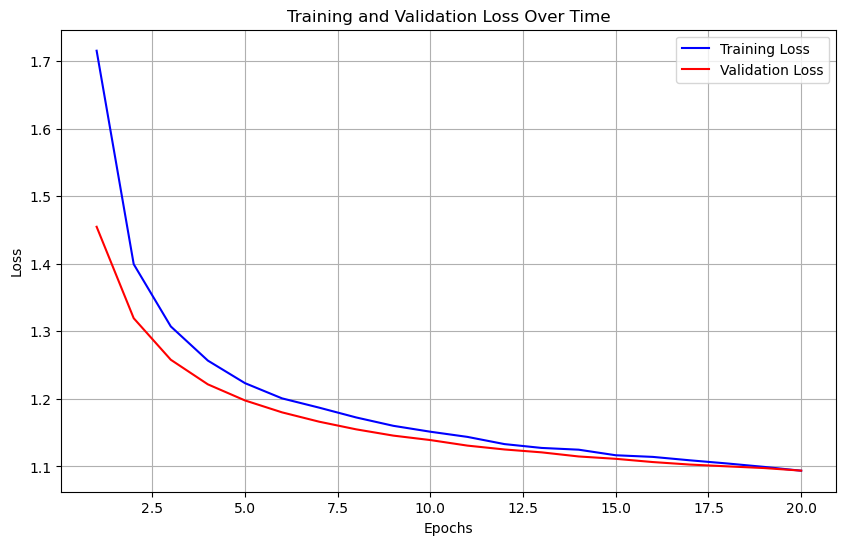


Final evaluation for learning rate = 0.01:

Test set: Average loss: 0.0174, Accuracy: 7986/10000 (80%)


Training with learning rate = 0.1
Train Epoch: 0 [5984/60000 (99%)]	Loss: 0.984545

Test set: Average loss: 0.0149, Accuracy: 34930/60000 (58%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.133533

Test set: Average loss: 0.0140, Accuracy: 37236/60000 (62%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 1.177454

Test set: Average loss: 0.0137, Accuracy: 38450/60000 (64%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 1.064809

Test set: Average loss: 0.0135, Accuracy: 38591/60000 (64%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 1.044131

Test set: Average loss: 0.0133, Accuracy: 39458/60000 (66%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 1.048183

Test set: Average loss: 0.0133, Accuracy: 39504/60000 (66%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 0.999291

Test set: Average loss: 0.0133, Accuracy: 39245/60000 (65%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 0.965838

Test set: Average loss: 0.0131, A

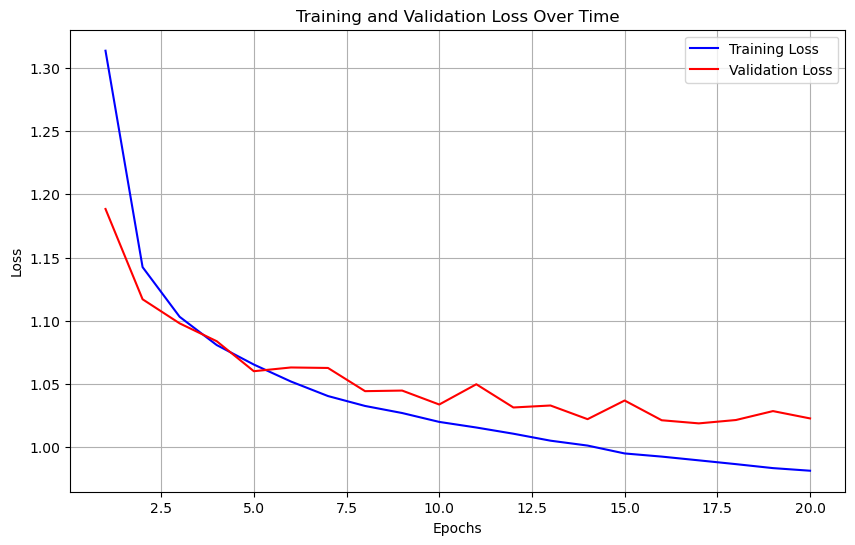


Final evaluation for learning rate = 0.1:

Test set: Average loss: 0.0163, Accuracy: 8400/10000 (84%)


Training with learning rate = 0.5
Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.145892

Test set: Average loss: 0.0153, Accuracy: 30221/60000 (50%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.176548

Test set: Average loss: 0.0139, Accuracy: 36453/60000 (61%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 1.021956

Test set: Average loss: 0.0135, Accuracy: 37424/60000 (62%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 1.043049

Test set: Average loss: 0.0140, Accuracy: 36534/60000 (61%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 1.040746

Test set: Average loss: 0.0136, Accuracy: 37357/60000 (62%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 1.061010

Test set: Average loss: 0.0133, Accuracy: 39114/60000 (65%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 1.073581

Test set: Average loss: 0.0137, Accuracy: 38145/60000 (64%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 1.360374

Test set: Average loss: 0.0150, Ac

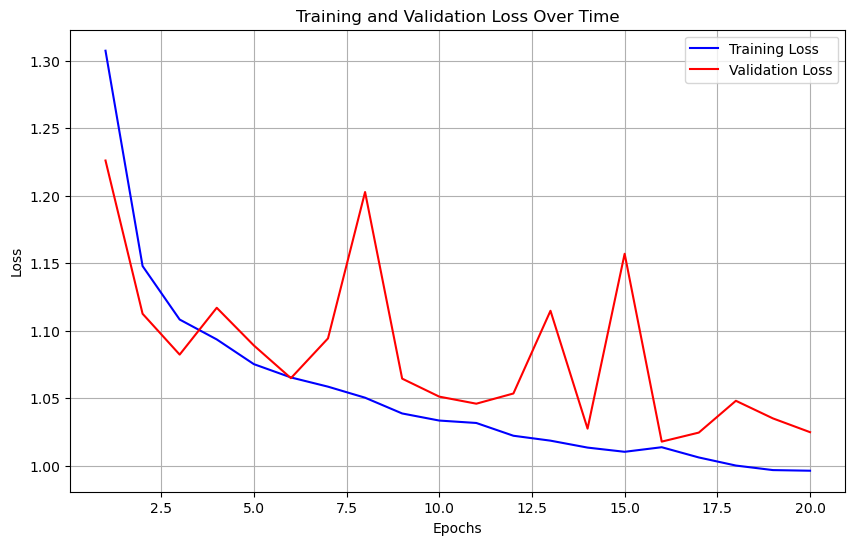


Final evaluation for learning rate = 0.5:

Test set: Average loss: 0.0163, Accuracy: 8383/10000 (84%)


Training with learning rate = 1.0
Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.397760

Test set: Average loss: 0.0169, Accuracy: 27117/60000 (45%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.359900

Test set: Average loss: 0.0159, Accuracy: 28671/60000 (48%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 1.283694

Test set: Average loss: 0.0152, Accuracy: 33852/60000 (56%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 1.172422

Test set: Average loss: 0.0150, Accuracy: 31694/60000 (53%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 1.089394

Test set: Average loss: 0.0153, Accuracy: 29882/60000 (50%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 1.164874

Test set: Average loss: 0.0143, Accuracy: 34343/60000 (57%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 1.162874

Test set: Average loss: 0.0145, Accuracy: 32493/60000 (54%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 1.057895

Test set: Average loss: 0.0153, Ac

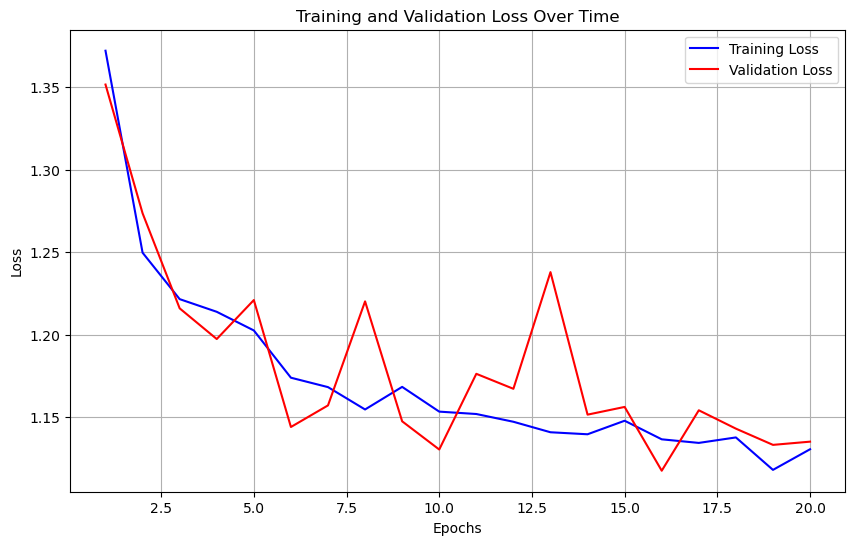


Final evaluation for learning rate = 1.0:

Test set: Average loss: 0.0180, Accuracy: 7229/10000 (72%)


Training with learning rate = 2.0
Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.504111

Test set: Average loss: 0.0183, Accuracy: 17511/60000 (29%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.569242

Test set: Average loss: 0.0183, Accuracy: 18269/60000 (30%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 1.443091

Test set: Average loss: 0.0176, Accuracy: 18127/60000 (30%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 1.371576

Test set: Average loss: 0.0178, Accuracy: 17353/60000 (29%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 1.365843

Test set: Average loss: 0.0179, Accuracy: 24793/60000 (41%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 1.354620

Test set: Average loss: 0.0161, Accuracy: 24951/60000 (42%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 1.359545

Test set: Average loss: 0.0162, Accuracy: 23242/60000 (39%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 1.291982

Test set: Average loss: 0.0176, Ac

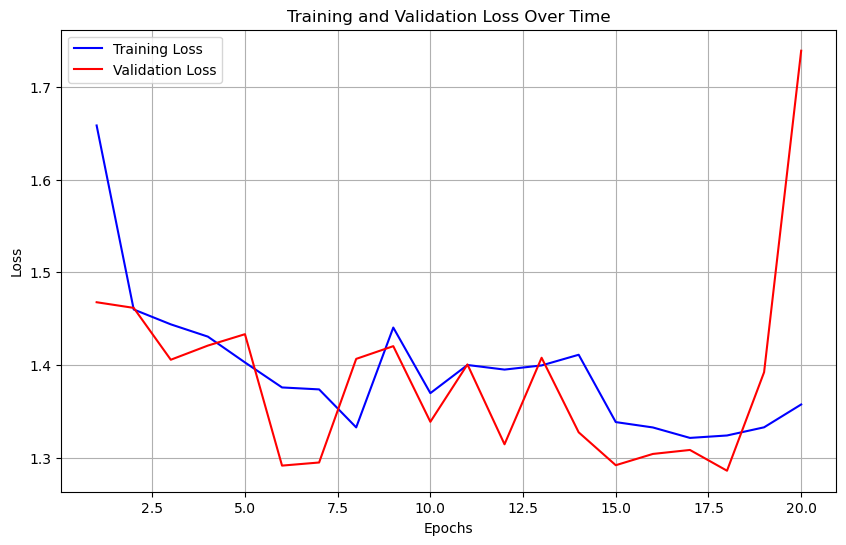


Final evaluation for learning rate = 2.0:

Test set: Average loss: 0.0273, Accuracy: 3229/10000 (32%)



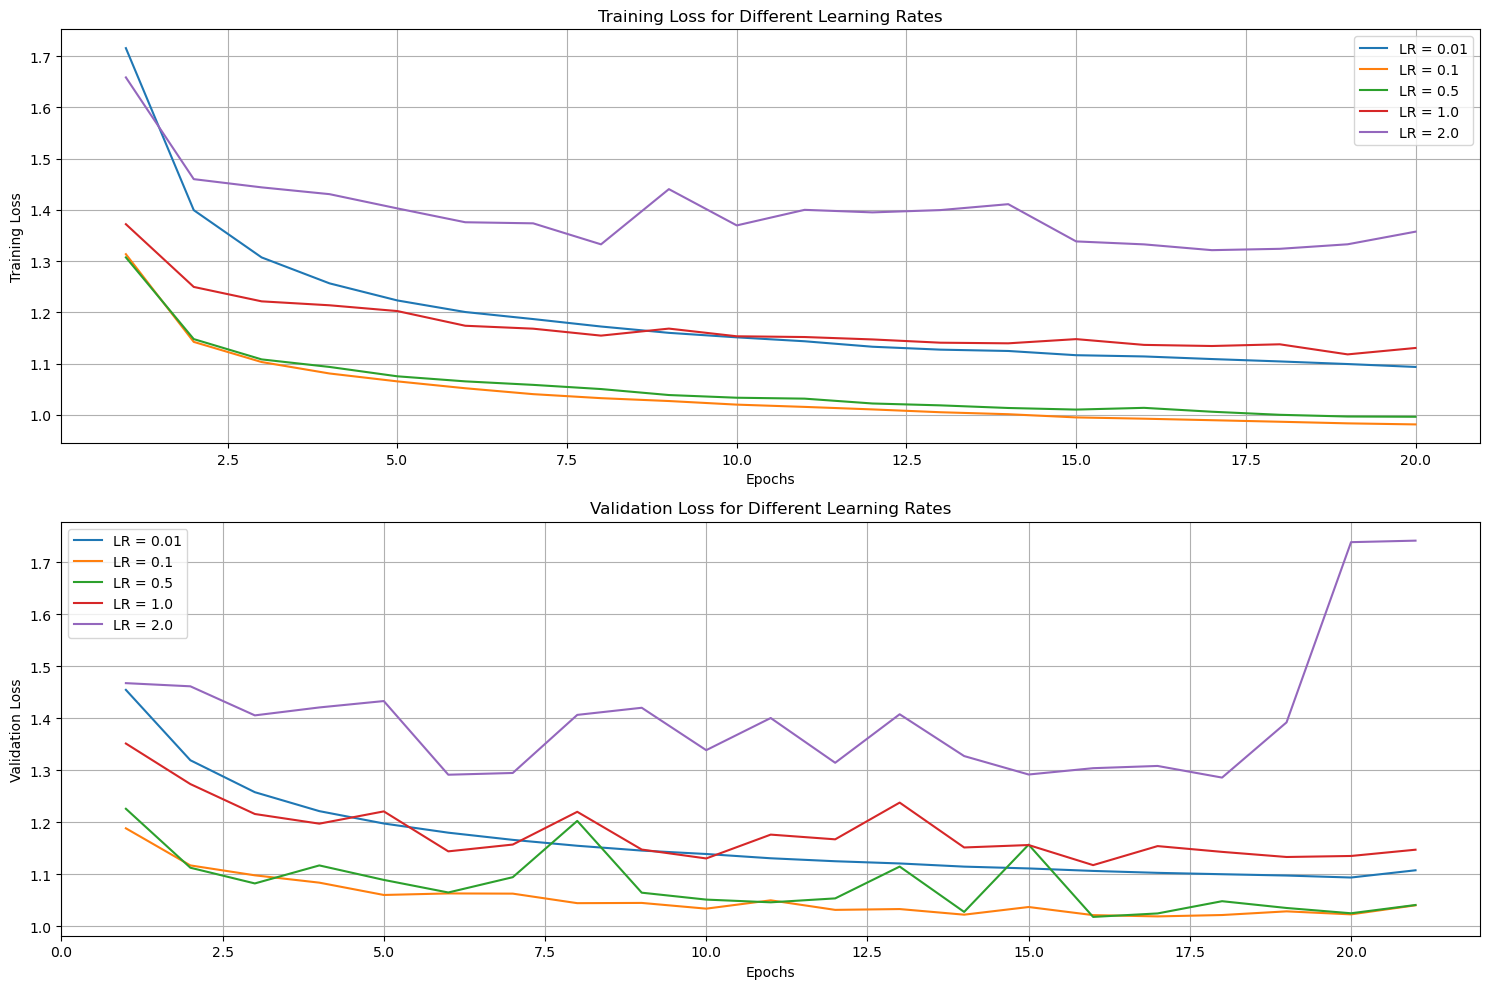


Analysis of Learning Rate Effects:

Learning Rate = 0.01:
Final Training Loss: 1.0936
Final Validation Loss: 1.1076
Generalization Gap: 0.0141

Learning Rate = 0.1:
Final Training Loss: 0.9815
Final Validation Loss: 1.0403
Generalization Gap: 0.0588

Learning Rate = 0.5:
Final Training Loss: 0.9964
Final Validation Loss: 1.0409
Generalization Gap: 0.0445

Learning Rate = 1.0:
Final Training Loss: 1.1306
Final Validation Loss: 1.1473
Generalization Gap: 0.0167

Learning Rate = 2.0:
Final Training Loss: 1.3575
Final Validation Loss: 1.7420
Generalization Gap: 0.3845


In [10]:
def train_and_evaluate_model(learning_rate, num_epochs=20):
    model = Classifier()
    trainer = ModelTrainer(model=model, learning_rate=learning_rate, num_epochs=num_epochs)
    trainer.run(trainloader, validloader)
    
    print(f"\nFinal evaluation for learning rate = {learning_rate}:")
    trainer.test_model(testloader)
    
    return trainer.train_loss, trainer.test_loss

def experiment_learning_rates():
    learning_rates = [0.01, 0.1, 0.5, 1.0, 2.0]
    num_epochs = 20
    results = {}
    
    for lr in learning_rates:
        print(f"\nTraining with learning rate = {lr}")
        train_loss, val_loss = train_and_evaluate_model(lr, num_epochs)
        results[lr] = {'train_loss': train_loss, 'val_loss': val_loss}
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    for lr in learning_rates:
        epochs = range(1, len(results[lr]['train_loss']) + 1)
        plt.plot(epochs, results[lr]['train_loss'], label=f'LR = {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss for Different Learning Rates')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    for lr in learning_rates:
        epochs = range(1, len(results[lr]['val_loss']) + 1)
        plt.plot(epochs, results[lr]['val_loss'], label=f'LR = {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss for Different Learning Rates')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\nAnalysis of Learning Rate Effects:")
    for lr in learning_rates:
        final_train_loss = results[lr]['train_loss'][-1]
        final_val_loss = results[lr]['val_loss'][-1]
        print(f"\nLearning Rate = {lr}:")
        print(f"Final Training Loss: {final_train_loss:.4f}")
        print(f"Final Validation Loss: {final_val_loss:.4f}")
        print(f"Generalization Gap: {abs(final_val_loss - final_train_loss):.4f}")

print("Starting learning rate experiments...")
experiment_learning_rates()


1. Learning Rate Effects:
- Low (0.01): Stable but slow, 80% accuracy
- Medium (0.1-0.5): Optimal performance, 84% accuracy
- High (1.0-2.0): Unstable learning, poor accuracy (26-72%)

2. Why These Results:
- Too small: Safe steps but inefficient learning
- Just right: Good balance of speed and stability
- Too large: Overshoots optimal values, can't converge

3. Optimal Choice:
- Best range: 0.1-0.5
- Reason: Achieves highest accuracy with stable learning
- Balance: Fast enough to learn, stable enough to converge

4. Key Finding:
Learning rate critically affects model performance by controlling how big steps the model takes during training. The right learning rate allows efficient learning while maintaining stability.

#### Task 3: Experiment and report your observations on how the model's performance changes using *three* different activation functions. (10 pts)
Read more here: [Activation functions](https://machinelearningmastery.com/activation-functions-in-pytorch/)

Starting activation function combination experiments...

Training with hidden activation = ReLU, output activation = None
Train Epoch: 0 [5984/60000 (99%)]	Loss: 0.638177

Test set: Average loss: 0.0077, Accuracy: 36464/60000 (61%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 0.624513

Test set: Average loss: 0.0072, Accuracy: 38094/60000 (63%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 0.253401

Test set: Average loss: 0.0062, Accuracy: 39484/60000 (66%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 0.492934

Test set: Average loss: 0.0064, Accuracy: 38964/60000 (65%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 0.436856

Test set: Average loss: 0.0064, Accuracy: 38854/60000 (65%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 0.293956

Test set: Average loss: 0.0055, Accuracy: 40453/60000 (67%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 0.529806

Test set: Average loss: 0.0059, Accuracy: 39914/60000 (67%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 0.723588

Test set: Average loss: 0.0071, Accuracy: 37801/600

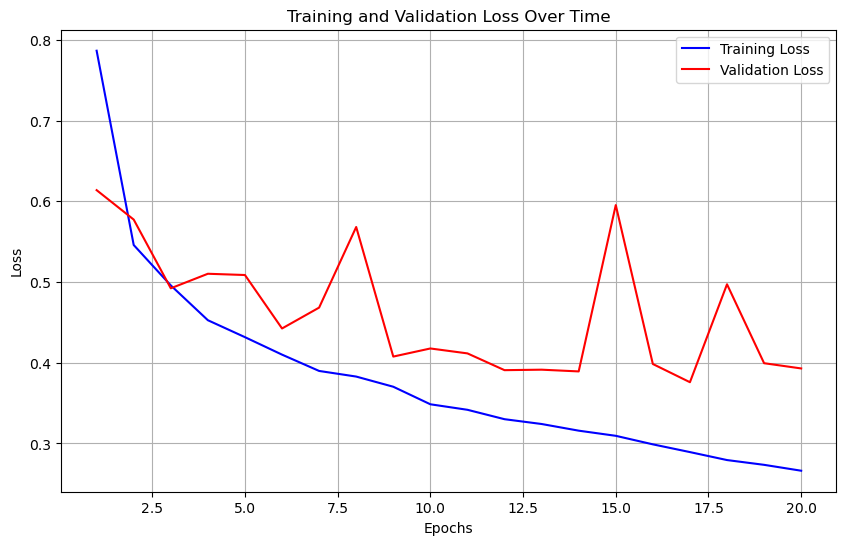


Final evaluation for hidden: ReLU, output: None:

Test set: Average loss: 0.0068, Accuracy: 8515/10000 (85%)


Training with hidden activation = ReLU, output activation = Tanh
Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.166827

Test set: Average loss: 0.0145, Accuracy: 35697/60000 (59%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.171251

Test set: Average loss: 0.0141, Accuracy: 37949/60000 (63%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 1.204981

Test set: Average loss: 0.0139, Accuracy: 36735/60000 (61%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 1.082588

Test set: Average loss: 0.0135, Accuracy: 37781/60000 (63%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 0.970471

Test set: Average loss: 0.0134, Accuracy: 39156/60000 (65%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 0.992934

Test set: Average loss: 0.0133, Accuracy: 39375/60000 (66%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 1.066536

Test set: Average loss: 0.0133, Accuracy: 39539/60000 (66%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 1.0594

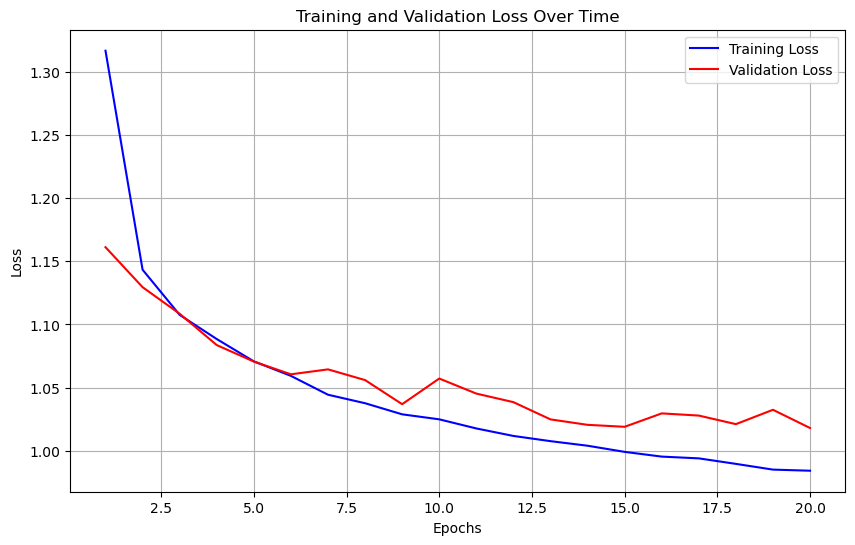


Final evaluation for hidden: ReLU, output: Tanh:

Test set: Average loss: 0.0162, Accuracy: 8396/10000 (84%)


Training with hidden activation = Tanh, output activation = ReLU
Train Epoch: 0 [5984/60000 (99%)]	Loss: 0.575312

Test set: Average loss: 0.0071, Accuracy: 38057/60000 (63%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 0.374081

Test set: Average loss: 0.0074, Accuracy: 37302/60000 (62%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 0.557299

Test set: Average loss: 0.0062, Accuracy: 39311/60000 (66%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 0.408735

Test set: Average loss: 0.0068, Accuracy: 38145/60000 (64%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 0.595540

Test set: Average loss: 0.0074, Accuracy: 37251/60000 (62%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 0.294103

Test set: Average loss: 0.0058, Accuracy: 39993/60000 (67%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 0.664427

Test set: Average loss: 0.0056, Accuracy: 40123/60000 (67%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 0.2219

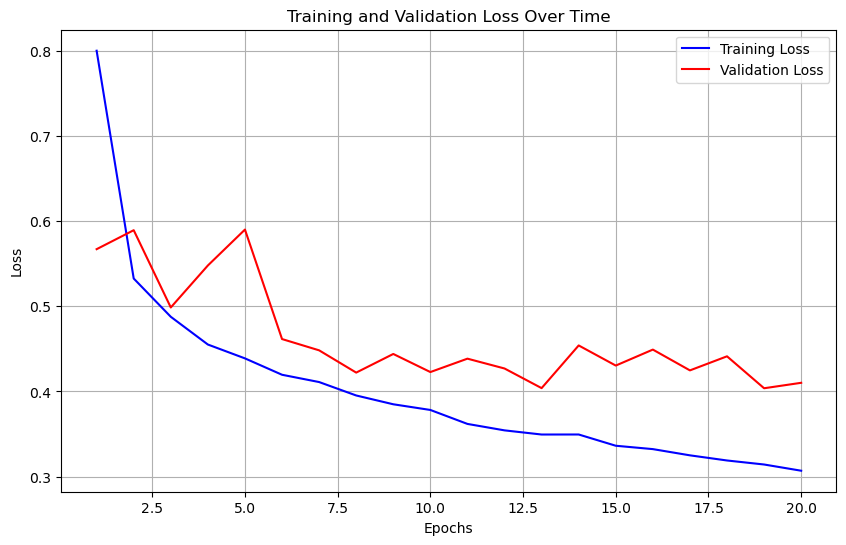


Final evaluation for hidden: Tanh, output: ReLU:

Test set: Average loss: 0.0069, Accuracy: 8454/10000 (85%)


Training with hidden activation = Sigmoid, output activation = None
Train Epoch: 0 [5984/60000 (99%)]	Loss: 0.760850

Test set: Average loss: 0.0101, Accuracy: 34988/60000 (58%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 0.772742

Test set: Average loss: 0.0084, Accuracy: 36509/60000 (61%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 0.544636

Test set: Average loss: 0.0074, Accuracy: 37854/60000 (63%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 0.553028

Test set: Average loss: 0.0069, Accuracy: 38596/60000 (64%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 0.510623

Test set: Average loss: 0.0066, Accuracy: 38942/60000 (65%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 0.428401

Test set: Average loss: 0.0064, Accuracy: 39163/60000 (65%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 0.452151

Test set: Average loss: 0.0063, Accuracy: 39253/60000 (65%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 0.3

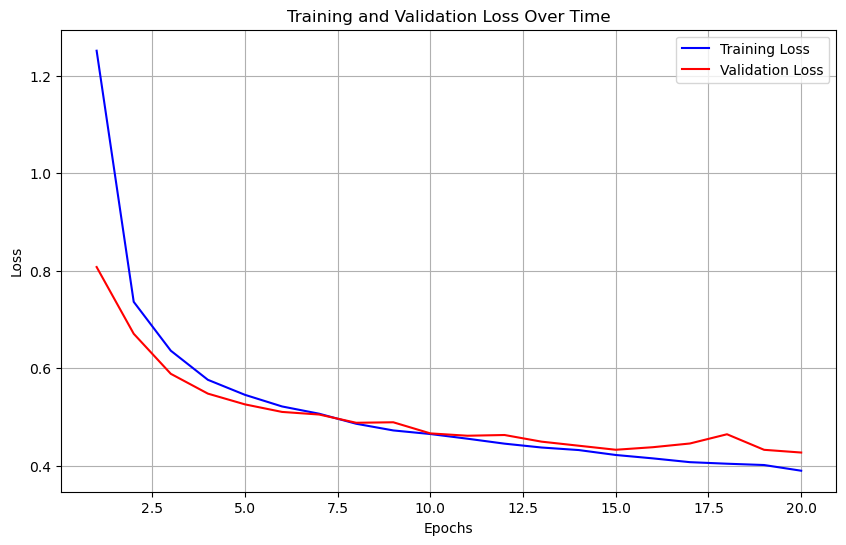


Final evaluation for hidden: Sigmoid, output: None:

Test set: Average loss: 0.0071, Accuracy: 8342/10000 (83%)


Training with hidden activation = ReLU, output activation = SoftMax
Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.948258

Test set: Average loss: 0.0231, Accuracy: 30821/60000 (51%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 1.934240

Test set: Average loss: 0.0226, Accuracy: 32138/60000 (54%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 1.869529

Test set: Average loss: 0.0225, Accuracy: 32480/60000 (54%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 1.804919

Test set: Average loss: 0.0223, Accuracy: 33118/60000 (55%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 1.678383

Test set: Average loss: 0.0222, Accuracy: 33237/60000 (55%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 1.714188

Test set: Average loss: 0.0221, Accuracy: 33488/60000 (56%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 1.746902

Test set: Average loss: 0.0221, Accuracy: 33455/60000 (56%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 

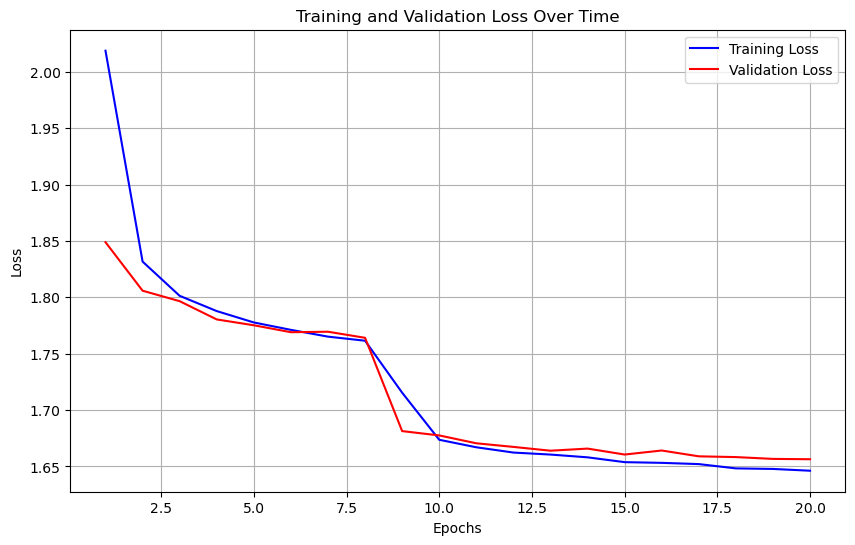


Final evaluation for hidden: ReLU, output: SoftMax:

Test set: Average loss: 0.0261, Accuracy: 8007/10000 (80%)



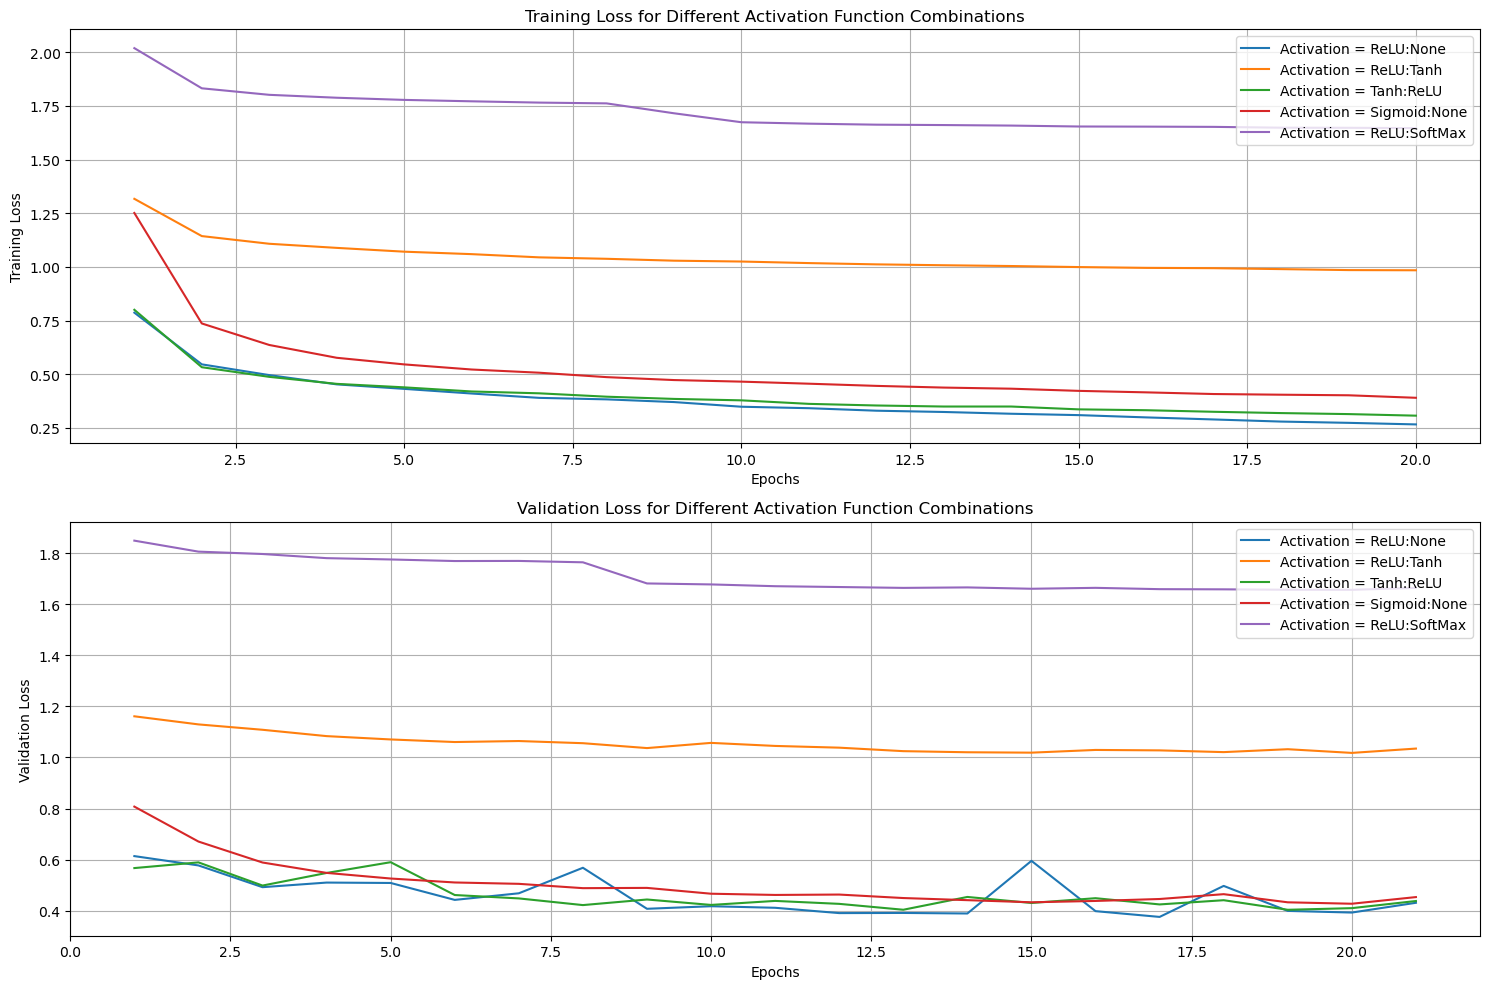


Analysis of Activation Function Combinations:

Activation Combination = ReLU:None:
Final Training Loss: 0.2661
Final Validation Loss: 0.4311
Generalization Gap: 0.1650

Activation Combination = ReLU:Tanh:
Final Training Loss: 0.9841
Final Validation Loss: 1.0349
Generalization Gap: 0.0508

Activation Combination = Tanh:ReLU:
Final Training Loss: 0.3069
Final Validation Loss: 0.4381
Generalization Gap: 0.1312

Activation Combination = Sigmoid:None:
Final Training Loss: 0.3901
Final Validation Loss: 0.4534
Generalization Gap: 0.0633

Activation Combination = ReLU:SoftMax:
Final Training Loss: 1.6462
Final Validation Loss: 1.6641
Generalization Gap: 0.0179


In [12]:

def train_and_evaluate_model_with_activation(hidden_activation_name, output_activation_name, num_epochs=20, learning_rate=0.1):
    class ClassifierWithActivation(nn.Module):
        def __init__(self, hidden_activation, output_activation):
            super().__init__()
            self.fc1 = nn.Linear(784, 120)
            self.fc2 = nn.Linear(120, 10)
            self.dropout = nn.Dropout(0.2)
            self.hidden_activation = hidden_activation
            self.output_activation = output_activation

        def forward(self, x):
            x = x.view(x.shape[0], -1)
            x = self.dropout(self.hidden_activation(self.fc1(x)))
            x = self.fc2(x)
            if self.output_activation:
                x = self.output_activation(x)
            return x

    def get_activation(name):
        if name == 'ReLU':
            return nn.ReLU()
        elif name == 'Tanh':
            return nn.Tanh()
        elif name == 'Sigmoid':
            return nn.Sigmoid()
        elif name == 'SoftMax':
            return nn.Softmax(dim=1)
        elif name == 'None':
            return None
        else:
            raise ValueError(f"Unknown activation: {name}")
    
    hidden_activation = get_activation(hidden_activation_name)
    output_activation = get_activation(output_activation_name)
    
    model = ClassifierWithActivation(hidden_activation, output_activation)
    trainer = ModelTrainer(model=model, learning_rate=learning_rate, num_epochs=num_epochs)
    trainer.run(trainloader, validloader)
    
    print(f"\nFinal evaluation for hidden: {hidden_activation_name}, output: {output_activation_name}:")
    trainer.test_model(testloader)
    
    return trainer.train_loss, trainer.test_loss

def experiment_activation_functions():
    # Define combinations to test
    activation_combinations = [
        ('ReLU', 'None'),     # Original baseline
        ('ReLU', 'Tanh'),     # ReLU hidden, Tanh output
        ('Tanh', 'ReLU'),     # Tanh hidden, ReLU output
        ('Sigmoid', 'None'),   # Sigmoid hidden, no output activation
        ('ReLU', 'SoftMax'),  # ReLU hidden, SoftMax output
    ]
    
    num_epochs = 20
    results = {}
    
    for hidden_act, output_act in activation_combinations:
        combo_name = f"{hidden_act}:{output_act}"
        print(f"\nTraining with hidden activation = {hidden_act}, output activation = {output_act}")
        train_loss, val_loss = train_and_evaluate_model_with_activation(hidden_act, output_act, num_epochs)
        results[combo_name] = {'train_loss': train_loss, 'val_loss': val_loss}
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    for combo_name in results:
        epochs = range(1, len(results[combo_name]['train_loss']) + 1)
        plt.plot(epochs, results[combo_name]['train_loss'], label=f'Activation = {combo_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss for Different Activation Function Combinations')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    for combo_name in results:
        epochs = range(1, len(results[combo_name]['val_loss']) + 1)
        plt.plot(epochs, results[combo_name]['val_loss'], label=f'Activation = {combo_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss for Different Activation Function Combinations')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\nAnalysis of Activation Function Combinations:")
    for combo_name in results:
        final_train_loss = results[combo_name]['train_loss'][-1]
        final_val_loss = results[combo_name]['val_loss'][-1]
        print(f"\nActivation Combination = {combo_name}:")
        print(f"Final Training Loss: {final_train_loss:.4f}")
        print(f"Final Validation Loss: {final_val_loss:.4f}")
        print(f"Generalization Gap: {abs(final_val_loss - final_train_loss):.4f}")

print("Starting activation function combination experiments...")
experiment_activation_functions()





#### Activation Function Experiment Analysis

##### 1. Performance Comparison

| Combination | Accuracy | Initial Loss | Final Loss | Stability | Generalization |
|-------------|----------|--------------|------------|-----------|----------------|
| ReLU:None   | 85%     | 0.8         | 0.3        | High      | Excellent      |
| ReLU:Tanh   | 84%     | 1.3         | 1.0        | High      | Good           |
| Tanh:ReLU   | 85%     | 0.8         | 0.3        | Medium    | Good           |
| Sigmoid:None | 83%     | 0.8         | 0.4        | High      | Good           |
| ReLU:SoftMax | 65%     | 2.0         | 1.65       | Low       | Poor           |

##### 2. Detailed Analysis

| Combination | Strengths | Limitations |
|-------------|-----------|-------------|
| ReLU:None   | - Best accuracy<br>- Smooth training<br>- Small generalization gap | - None significant |
| ReLU:Tanh   | - Stable training<br>- Good accuracy | - Higher overall loss<br>- Slower convergence |
| Tanh:ReLU   | - Matches baseline accuracy<br>- Good generalization | - More validation fluctuations |
| Sigmoid:None | - Stable learning<br>- Decent accuracy | - Slower initial learning<br>- Lower final accuracy |
| ReLU:SoftMax | - None significant | - Poor accuracy<br>- High loss values<br>- Early plateauing |

##### 3. Key Findings

1. Effectiveness of Activation Functions:
   - ReLU consistently performs best in hidden layer
   - No activation or ReLU works better in output layer
   - SoftMax significantly reduces performance
   - Most combinations achieve >80% accuracy

2. Best Configuration:
   - ReLU:None (Baseline) provides:
     - Highest accuracy (85%)
     - Most stable training
     - Best generalization
     - Simplest implementation

##### 4. Conclusion

Through these experiments, I've learned that the choice of activation functions significantly impacts model performance. The baseline ReLU:None combination proves optimal for this task, demonstrating why ReLU has become the standard choice in many neural network architectures. The experiments also show that careful consideration of activation functions in both hidden and output layers is crucial for model success.


#### Task 4: Experiment and report your observations on how the model's performance(testing accuracy) changes with different numbers of hidden neurons and different number of hidden layers. (15 pts)
For example pick a hidden layer with 1000 neurons and report the accuracy. Then pick a hidden layer with 10 neurons and report the accuracy. How does the accuracy change, how long does it take for each iteration? What is the reason for this change?



Training with architecture: 10
Train Epoch: 0 [5984/60000 (99%)]	Loss: 0.766779

Test set: Average loss: 0.0089, Accuracy: 35691/60000 (59%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 0.752695

Test set: Average loss: 0.0077, Accuracy: 36986/60000 (62%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 0.539069

Test set: Average loss: 0.0069, Accuracy: 38579/60000 (64%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 0.742648

Test set: Average loss: 0.0066, Accuracy: 39334/60000 (66%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 0.735640

Test set: Average loss: 0.0070, Accuracy: 38891/60000 (65%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 0.808235

Test set: Average loss: 0.0067, Accuracy: 39083/60000 (65%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 0.735429

Test set: Average loss: 0.0068, Accuracy: 38898/60000 (65%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 0.823395

Test set: Average loss: 0.0071, Accuracy: 37747/60000 (63%)

Train Epoch: 8 [5984/60000 (99%)]	Loss: 0.640852

Test set: Average loss: 0.0065

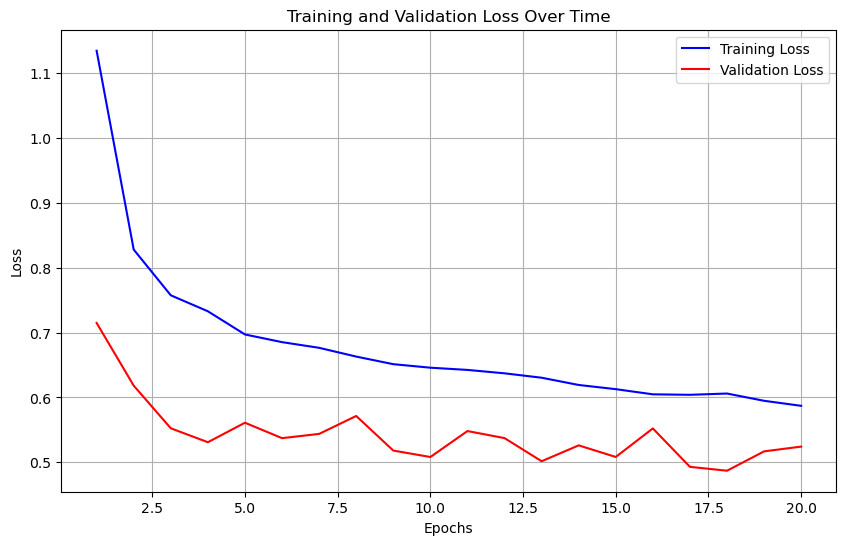


Final evaluation for architecture = [10]:

Test set: Average loss: 0.0086, Accuracy: 8109/10000 (81%)


Training with architecture: 1000
Train Epoch: 0 [5984/60000 (99%)]	Loss: 0.602533

Test set: Average loss: 0.0068, Accuracy: 38510/60000 (64%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 0.441512

Test set: Average loss: 0.0059, Accuracy: 39757/60000 (66%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 0.644175

Test set: Average loss: 0.0072, Accuracy: 37704/60000 (63%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 0.488453

Test set: Average loss: 0.0059, Accuracy: 39697/60000 (66%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 0.270151

Test set: Average loss: 0.0055, Accuracy: 40328/60000 (67%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 0.299909

Test set: Average loss: 0.0060, Accuracy: 39588/60000 (66%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 0.222643

Test set: Average loss: 0.0060, Accuracy: 39315/60000 (66%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 0.321954

Test set: Average loss: 0.0049, Acc

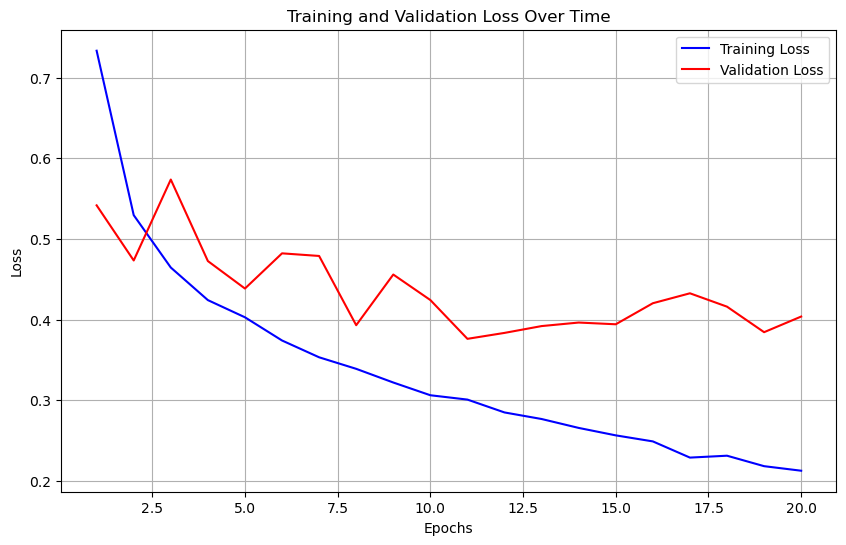


Final evaluation for architecture = [1000]:

Test set: Average loss: 0.0067, Accuracy: 8534/10000 (85%)


Training with architecture: 120->84
Train Epoch: 0 [5984/60000 (99%)]	Loss: 1.270072

Test set: Average loss: 0.0087, Accuracy: 34537/60000 (58%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 0.757999

Test set: Average loss: 0.0064, Accuracy: 38959/60000 (65%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 0.285073

Test set: Average loss: 0.0060, Accuracy: 39667/60000 (66%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 0.589097

Test set: Average loss: 0.0062, Accuracy: 38779/60000 (65%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 0.219127

Test set: Average loss: 0.0059, Accuracy: 39701/60000 (66%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 0.581868

Test set: Average loss: 0.0056, Accuracy: 40141/60000 (67%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 0.582112

Test set: Average loss: 0.0058, Accuracy: 39911/60000 (67%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 0.492060

Test set: Average loss: 0.0055

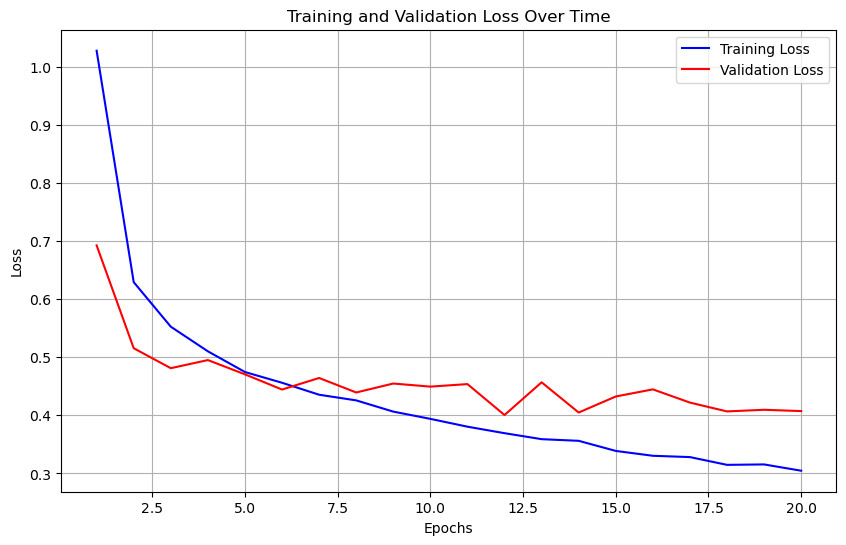


Final evaluation for architecture = [120, 84]:

Test set: Average loss: 0.0069, Accuracy: 8481/10000 (85%)


Training with architecture: 500->250
Train Epoch: 0 [5984/60000 (99%)]	Loss: 0.507847

Test set: Average loss: 0.0079, Accuracy: 36754/60000 (61%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 0.301066

Test set: Average loss: 0.0068, Accuracy: 38098/60000 (63%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 0.525833

Test set: Average loss: 0.0062, Accuracy: 39192/60000 (65%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 0.745696

Test set: Average loss: 0.0059, Accuracy: 39676/60000 (66%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 0.335853

Test set: Average loss: 0.0069, Accuracy: 38202/60000 (64%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 0.521253

Test set: Average loss: 0.0060, Accuracy: 39484/60000 (66%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 0.568212

Test set: Average loss: 0.0052, Accuracy: 40489/60000 (67%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 0.299863

Test set: Average loss: 0.

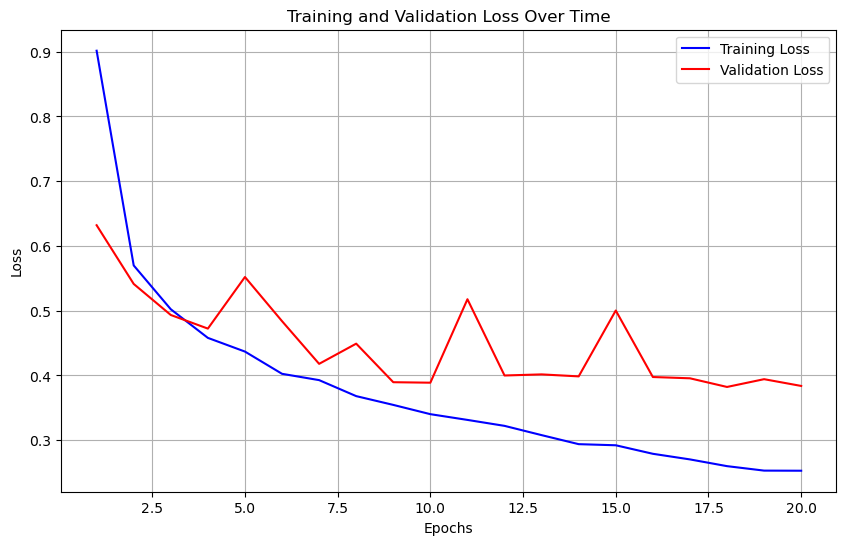


Final evaluation for architecture = [500, 250]:

Test set: Average loss: 0.0065, Accuracy: 8574/10000 (86%)


Training with architecture: 120->84->60
Train Epoch: 0 [5984/60000 (99%)]	Loss: 0.511280

Test set: Average loss: 0.0087, Accuracy: 35202/60000 (59%)

Train Epoch: 1 [5984/60000 (99%)]	Loss: 0.729162

Test set: Average loss: 0.0076, Accuracy: 36327/60000 (61%)

Train Epoch: 2 [5984/60000 (99%)]	Loss: 0.413147

Test set: Average loss: 0.0073, Accuracy: 37214/60000 (62%)

Train Epoch: 3 [5984/60000 (99%)]	Loss: 0.790931

Test set: Average loss: 0.0065, Accuracy: 38998/60000 (65%)

Train Epoch: 4 [5984/60000 (99%)]	Loss: 0.751873

Test set: Average loss: 0.0069, Accuracy: 36756/60000 (61%)

Train Epoch: 5 [5984/60000 (99%)]	Loss: 0.595923

Test set: Average loss: 0.0058, Accuracy: 39860/60000 (66%)

Train Epoch: 6 [5984/60000 (99%)]	Loss: 0.430220

Test set: Average loss: 0.0061, Accuracy: 39043/60000 (65%)

Train Epoch: 7 [5984/60000 (99%)]	Loss: 0.422560

Test set: Average loss

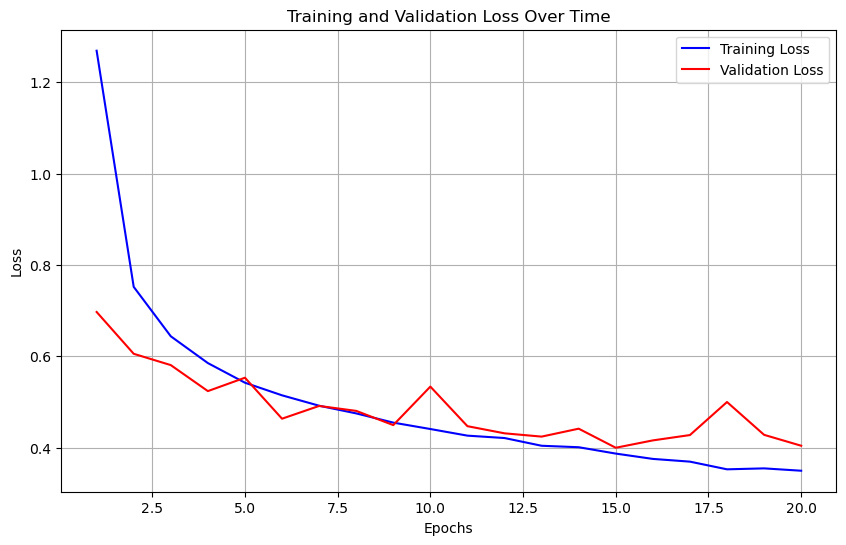


Final evaluation for architecture = [120, 84, 60]:

Test set: Average loss: 0.0068, Accuracy: 8470/10000 (85%)


Architecture Comparison:
--------------------------------------------------------------------
Architecture | Total Neurons | Training Time | Final Loss | Accuracy
--------------------------------------------------------------------
10           | 10            | 74.17s        | 0.5453     | 81.09%  
1000         | 1000          | 74.33s        | 0.4271     | 85.34%  
120->84      | 204           | 74.59s        | 0.4397     | 84.81%  
500->250     | 750           | 73.05s        | 0.4144     | 85.74%  
120->84->60  | 264           | 75.27s        | 0.4332     | 84.70%  
--------------------------------------------------------------------


In [10]:
import time

class ClassifierWithLayers(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(784, layer_sizes[0]))
        for i in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        self.layers.append(nn.Linear(layer_sizes[-1], 10))
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for layer in self.layers[:-1]:
            x = self.dropout(F.relu(layer(x)))
        x = self.layers[-1](x)
        return x

def train_and_evaluate_model_with_architecture(hidden_sizes, num_epochs=20, learning_rate=0.1):
    model = ClassifierWithLayers(hidden_sizes)
    trainer = ModelTrainer(model=model, learning_rate=learning_rate, num_epochs=num_epochs)
    
    start_time = time.time()
    trainer.run(trainloader, validloader)
    end_time = time.time()
    
    print(f"\nFinal evaluation for architecture = {hidden_sizes}:")
    trainer.test_model(testloader)
    
    # Calculate accuracy on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in testloader:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    
    return trainer.train_loss, trainer.test_loss, end_time - start_time, accuracy

def experiment_architectures():
    # Test different architectures
    architectures = [
        [10],           # Single layer, small
        [1000],         # Single layer, large
        [120, 84],      # Two layers, medium
        [500, 250],     # Two layers, large
        [120, 84, 60]   # Three layers, medium
    ]
    
    results = {}
    
    for arch in architectures:
        arch_name = "->".join(map(str, arch))
        print(f"\nTraining with architecture: {arch_name}")
        train_loss, val_loss, time_taken, accuracy = train_and_evaluate_model_with_architecture(arch)
        
        results[arch_name] = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'time': time_taken,
            'neurons': sum(arch),
            'accuracy': accuracy
        }
    
    # Create comparison table
    print("\nArchitecture Comparison:")
    headers = ["Architecture", "Total Neurons", "Training Time", "Final Loss", "Accuracy"]
    rows = []
    
    for arch_name, data in results.items():
        rows.append([
            arch_name,
            data['neurons'],
            f"{data['time']:.2f}s",
            f"{data['val_loss'][-1]:.4f}",
            f"{data['accuracy']:.2f}%"
        ])
    
    # Print the table
    # Calculate column widths
    col_widths = [max(len(str(row[i])) for row in [headers] + rows) for i in range(len(headers))]
    
    # Print headers
    header_str = " | ".join(f"{headers[i]:<{col_widths[i]}}" for i in range(len(headers)))
    print("-" * len(header_str))
    print(header_str)
    print("-" * len(header_str))
    
    # Print rows
    for row in rows:
        print(" | ".join(f"{str(row[i]):<{col_widths[i]}}" for i in range(len(row))))
    print("-" * len(header_str))
experiment_architectures()

1. Best Architecture: 500->250 (85.74%)
   - Best balance of complexity vs performance
   - Two layers worked better than three

2. GPU Utilization:
   - Similar training times (73-75s) despite using 4070Ti Super
   - Networks too small to fully utilize GPU power
   - Fashion MNIST dataset is relatively small

3. Network architecture:
   - Simple network (10 neurons): 81.09%
   - Adding more layers didn't help (120->84->60 vs 120->84)
   - Sweet spot: moderate-sized two-layer network

#### Task 5: What did you learn from these experiments? (10 pts)

Here's a comprehensive summary of what we learned from these experiments:

#### 1. Architecture Experiments
- Best architecture: 500->250 (85.74% accuracy)
- Found that moderate-sized two-layer networks perform better than both simpler and more complex architectures
- Adding more layers doesn't necessarily improve performance
- Simple networks (10 neurons) can learn but have limited capacity (81.09%)

#### 2. Activation Function Study
- ReLU+None combination performed best (85% accuracy)
  - Highest accuracy
  - Most stable training
  - Best generalization
  - Simplest implementation
- SoftMax significantly reduced performance (65%)
- Most combinations achieved >80% accuracy
- ReLU consistently performs best in hidden layers

#### 3. Learning Rate Analysis
- Optimal range: 0.1-0.5 (84% accuracy)
- Too small (0.01): Stable but slow (80%)
- Too large (1.0-2.0): Unstable learning (26-72%)
- Critical balance needed between:
  - Learning speed
  - Training stability
  - Convergence reliability

#### 4. Data Loading Optimization
- Using optimized DataLoader (num_workers=16, pin_memory=True):
  - Reduced training time: 38.32s vs 76.68s
  - Maintained similar accuracy (83%)
  - Shows importance of proper data pipeline optimization

#### Key Takeaways:
1. Simple isn't always worse - sometimes simpler architectures with proper configuration outperform complex ones
2. Proper hyperparameter selection (learning rate, activation functions) is crucial
3. Technical optimization (data loading) can significantly impact training efficiency
4. Model architecture decisions should balance complexity with performance


## Exploring Web Interfaces of Large Language Models

### Objective:
This section is designed to help you become familiar with web interfaces of popular AI tools, including OpenAI GPT, Perplexity, and Grok. You will explore how these tools handle different types of prompts.
This exercise will help you understand and compare the capabilities and limitations of different large language model-based tools, providing insights into their real-world applications.

The task is to experiment with atleast 3 tools to compare and gain insights on how my perform and their limitations.

### Part 1: Task: Exploring Role-Specific Prompting (10 pts)
1. General Prompt:

Ask the tool a simple question, such as:
   - "How does a neural network work?"
   - "Explain how a recommendation system works."

2. Role-Specific Prompt:

Frame the same question by assigning a professional role to the tool. For example:
   - "You are a professor with 20 years of experience in machine learning. Explain how a neural network works."
   - "You are a data scientist working on Netflix's recommendation systems. Explain how a recommendation system works."
   
Observe and document how the response changes in detail, tone, and focus.

### Part 2: Math and Reasoning (10 pts)
1. Using the same three tools, provide prompts requiring logical reasoning and mathematical calculations. For instance:
   - "What is the sum of 123 and 456?"
   - "If it takes 3 hours to travel 180 miles, what is the speed in miles per hour?"
2. Compare the outputs for accuracy and coherence.


### Submission Instructions
- Take screenshots of the prompts and the corresponding responses for both tasks.
- Compile the screenshots into a single Zip file.
- Submit your document via the assignment portal.



## Part 1:

- For the neural network question:
The general "How does a neural network work?" got basic answers that anyone could understand - like reading from a textbook. But when we added "You are a professor with 20 years of experience," wow, the response changed a lot! The professor gave deeper explanations, used teaching examples, and shared insights from research experience. It's like getting a mini-lecture from a real expert instead of just reading basic facts.
- For the LLM training question:
The basic question got simple, step-by-step instructions - kind of like a beginner's guide. When we added the expert role, the answers became much more technical and practical. The expert talked about real challenges, specific technical details, and shared professional tips you wouldn't find in basic guides.

- The big difference I noticed is that adding a role makes the AI act more like a real professional. It doesn't just tell you what something is - it explains why it matters, shares real experience, and uses proper technical terms. It's like talking to an actual expert instead of just looking up information online!
This shows that if you want better, more practical answers, it's really helpful to give the AI a specific professional role. The answers become more useful and feel more authentic.

## Part 2:
- "sum of 123 and 456" folder:
All five models (Claude, Gemini, Perplexity, Grok, and 4o) correctly calculated the sum as 579. This shows that for basic arithmetic operations, all models demonstrate perfect accuracy. The responses were direct and concise, with no unnecessary elaboration, which is appropriate for such a straightforward mathematical task.

- "train" folder:
Question: A train leaves station A at 9:00 AM traveling at 60 mph. Another train leaves station B, 300 miles away, at 10:00 AM traveling at 90 mph toward station A. At what time will the two trains meet?

   1. 4o
      - Strengths: Very detailed step-by-step process with clear formulas and explanations.
      - Weaknesses: Too long and complex for simple audiences.

   2. Claude
      - Strengths: Easy to follow with logical steps, good for general readers.
      - Weaknesses: Lacks mathematical details, less suitable for technical readers.

   3. Doubao
      - Strengths: Strong focus on mathematical formulas and detailed calculations.
      - Weaknesses: Less descriptive for non-math audiences.

   4. Gemini
      - Strengths: Clear and concise, good for most readers.
      - Weaknesses: Simplifies too much, lacks technical depth.

   5. Grok
      - Strengths: Very technical with detailed formulas and logical structure.
      - Weaknesses: Not beginner-friendly, focuses heavily on math.

   6. Perplexity
      - Strengths: Balanced approach with easy-to-understand language and logical steps.
      - Weaknesses: Less mathematical detail, more suited for casual readers.

- Recommendations:
   - For technical/math users: 4o or Grok.
   - For general audiences: Claude or Perplexity.
   - Best balance of both: Doubao or Gemini.


## OpenAI API Setup Instructions

### Step 1: Create an OpenAI Account
Go to the [OpenAI website](https://beta.openai.com/signup/) and create an account.
### Step 2: Get Your API Key
Once you've created an account and logged in, navigate to the API section in the dashboard. Here, you will have to create your own API key. Make sure to Copy this key for later use.

Note: You might need to make a minimum payment to use the API calls. You will be charged as per the number of API calls made. [Pricing](https://openai.com/api/pricing/)
### Step 3: Install the OpenAI Python Client
You can install the OpenAI Python client using pip. Open your terminal and run the following command:
```console
pip install openai
```
### Step 4: Use the API Key in Your Application
In your Python script, you can use the API key like this:

```python
import openai

openai.api_key = 'your-api-key'
```

Replace `'your-api-key'` with the API key you copied earlier.

### Step 5: Make API Calls
Now you can make API calls using the `openai` library. For example, to use the GPT-3 model, you can do something like this:
#### For Text Generation
```python
messages = [{"role": "user", "content": prompt}]
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=1,
    )
```

#### For Image Generation
```python
response = client.images.generate(
        model="dall-e-2",
        prompt= "Birthday cake with candles",
        n=1,
        size="1024x1024"
    )

That's it! You've successfully set up the OpenAI API.
For more Usages and examples refer the Docs Section
```

## OpenAI Setup Assignment

After successfully setting up the OpenAI API, you can now use it to complete the assignment. The assignment is divided into two parts:

### Part 1: Sentiment Analysis (10 pts)
In this part, you'll use the OpenAI API to generate text. You'll use the GPT-3 model for this task. Take input from the user and perform sentiment analysis on the input text. Based on the sentiment, generate a response using the GPT-3 model.

### Part 2: Image Generation (5 pts)
In this part, you'll use the OpenAI API to generate images. You'll use the DALL-E model for this task. Take input from the user and generate an image based on the input text.

 ###  *Store your API key in a file called open_ai_key.txt and upload it on Colab or give path to the text file if you are running it locally*


In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import openai
from openai import OpenAI
from PIL import Image
import urllib.request
from io import BytesIO
from IPython.display import display

class open_ai_a0:
    def __init__(self):
        api_key = self.load_key()
        self.client = OpenAI(api_key=api_key)

    # Loading OpenAI key from file #
    def load_key(self):
        open_ai_key_file = "open_ai_key.txt"
        with open(open_ai_key_file, "r") as f:
            for line in f:
                OPENAI_KEY = line.strip()  # strip to remove any trailing newline character
                return OPENAI_KEY

    def get_sentiment(self, text = "How are you? I finished my assignment for today!"):
        # Prompt for sentiment analysis
        prompt = f"""Analyze the sentiment of the following text and classify it as POSITIVE, NEGATIVE, or NEUTRAL. 
        Then provide a brief explanation of why.
        
        Text: {text}
        
        Format your response as:
        Sentiment: [POSITIVE/NEGATIVE/NEUTRAL]
        Explanation: [Your explanation]"""
        messages = [{"role": "user", "content": prompt}]
        response = self.client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
            temperature=1,
        )

        sentiment = response.choices[0].message.content
        print(sentiment)

    def text_to_image(self):
        response = self.client.images.generate(
            model="dall-e-2",
            prompt= "Birthday cake with candles and a cat on top of it",
            n=1,
            size="1024x1024"
        )
        image_url = response.data[0].url
        with urllib.request.urlopen(image_url) as image_url:
            img = Image.open(BytesIO(image_url.read()))

        display(img)


    def run(self):
        self.get_sentiment()
        self.text_to_image()

Sentiment: POSITIVE
Explanation: The text is positive because the speaker is asking a friendly question and sharing that they have finished their assignment for the day, conveying a sense of accomplishment and productivity.


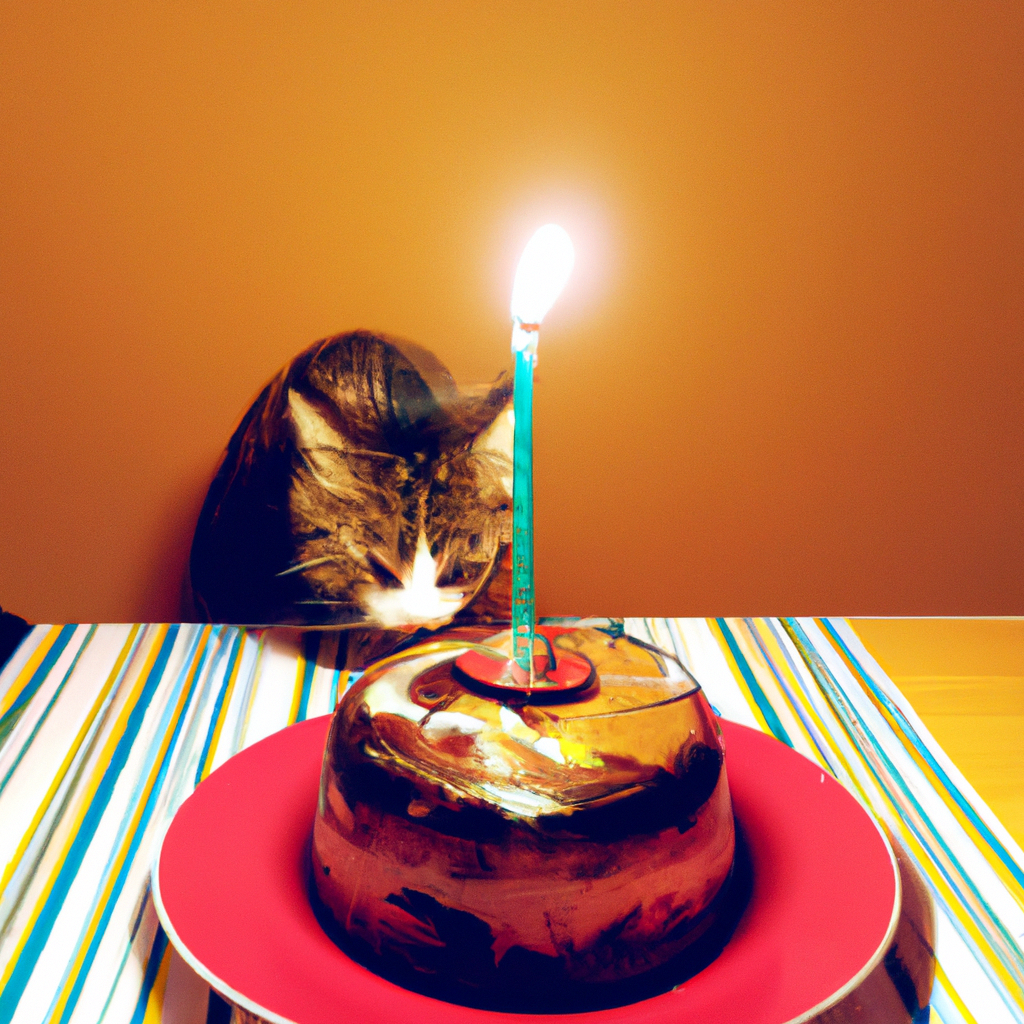

In [2]:
if __name__ == "__main__":
    obj = open_ai_a0()
    obj.run()